<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [95]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [0]:
# General packages not sure anymore what I'm actually using lol
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import feature_selection

# General packages
import numpy as np 
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


# import classifier SVC
from sklearn.svm import SVC

In [97]:
# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # All data without column 'label'
Y = data['label'] 
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # convert AD and CN to 1 and 0
print("number of AD patients:")
print((list(data['label'] == 0)).count(True)) # displays number AD patients
print("number of CN patients:")
print((list(data['label'] == 0)).count(False)) # displays number of CN patients 


The number of samples: 855
The number of columns: 268
number of AD patients:
336
number of CN patients:
519


In [98]:
# split into train (70%) and test (30%) set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(598, 267) (598,)
(257, 267) (257,)


In [100]:
# Preprocessing: drop feature if too many missing values

X_train = X_train.replace(0, np.NaN)                                    # replace 0 with NaN
missing_per_feature_train = X_train.isnull().sum()                      # gives the amount of missing values (NaN) per feature
pct_null_train = missing_per_feature_train / len(X_train)               # gives percentage of missing values per feature
missing_features_train = pct_null_train[pct_null_train > 0.40].index    # gives features with more than 40% missing values
X_train.drop(missing_features_train, axis=1, inplace=True)              # remove feature if more than 40% missing values

X_test = X_test.replace(0, np.NaN)                                      # replace 0 with NaN
missing_per_feature_test = X_test.isnull().sum()                        # gives the amount of missing values (NaN) per feature
pct_null_test = missing_per_feature_test / len(X_test)                  # gives percentage of missing values per feature
missing_features_test = pct_null_test[pct_null_train > 0.40].index      # gives features with more than 40% missing values
X_test.drop(missing_features_test, axis=1, inplace=True)                # remove feature if more than 40% missing values

missing_per_feature_max_train = max(X_train.isnull().sum())             # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features
missing_per_feature_max_test = max(X_test.isnull().sum())               # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features

print(missing_per_feature_max)
print (X_train.shape, y_train.shape)

94
(598, 261) (598,)


In [101]:
# Preprocessing:  impute missing values (fill missing)

imputer = impute.SimpleImputer(strategy='mean')       # imputer with mean 
X_train_imp = imputer.fit_transform(X_train)          # impute  
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df

X_test_imp = imputer.fit_transform(X_test)            # impute  
X_test_imp = pd.DataFrame(data=X_test_imp, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df

type(X_train_imp)


pandas.core.frame.DataFrame

In [0]:
# Preprocessing: scaling either standard or robust (removes median and scales data according to quantile range) 

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)        # scaling the training data

scaler.fit_transform(X_test_imp)
X_test_scaled = scaler.transform(X_test_imp)          # scaling the test data

X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df
X_test_scaled = pd.DataFrame(data=X_test_scaled, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df



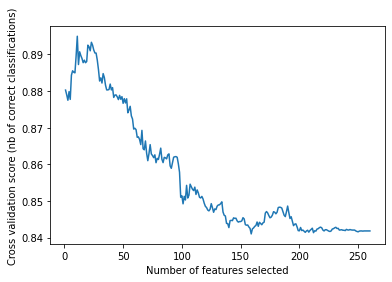

In [0]:
# Code for feature selection
'''
First determine the best amount of features
'''

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")
X= X_train_scaled.iloc[:,1:261]
y= y_train

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [0]:
# Code for feature selection
'''
With the amount of features desired known, find the best performing features
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
#apply SelectKBest class to extract top ... best features
bestfeatures = SelectKBest(score_func= f_classif, k=32) # k= number of desired features
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(32,'Score'))  #print ... best features 

                                            Specs       Score
0                                   (hf_entropy,)  427.427213
217                          (tf_LBP_std_R3_P12,)  334.302007
1                                  (hf_kurtosis,)  334.233558
7                            (hf_quartile_range,)  319.800005
10                                      (hf_std,)  290.500809
110                  (tf_GLRLM_ShortRunEmphasis,)  236.059742
99                  (tf_GLRLM_GrayLevelVariance,)  231.468762
98   (tf_GLRLM_GrayLevelNonUniformityNormalized,)  226.803663
112      (tf_GLRLM_ShortRunLowGrayLevelEmphasis,)  225.566689
72              (phasef_phasesym_entropy_WL3_N5,)  202.821690
133                      (tf_Gabor_0.05A0.0skew,)  180.773030
108                     (tf_GLRLM_RunPercentage,)  173.191494
5                                       (hf_min,)  160.641596
101                   (tf_GLRLM_LongRunEmphasis,)  158.384793
202                     (tf_LBP_kurtosis_R3_P12,)  154.227872
75      

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [207 210 211 212] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [110]:
# Random Forest Classifier

# Set parameters
parameters = {"n_estimators": list(range(1, 20, 2))}
    # nog een range kiezen

scores = ['precision']

for score in scores:
    print('# Random Forest Classifier')
    print("# Tuning hyper-parameters for %s" % score)
    print()
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(
        rfc, parameters, scoring='%s_macro' % score
    ) 
    # cv is nu default, dus een kfold van 5! 
    grid_search.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    clf = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print(best_parameters)
    print()
    print("Grid score on development set:")
    print()
    score = grid_search.best_score_
    print(score)
    print()

# test data
print("# Evaluate with test data set")
y_true, y_pred = y_test, clf.predict(X_test_scaled)

auc=metrics.roc_auc_score(y_true, y_pred)
print(f'AUC:{auc}')
accuracy=metrics.accuracy_score(y_true, y_pred)
print(f'accuracy:{accuracy}')
F1=metrics.f1_score(y_true,y_pred)
print(f'F1:{F1}')
precision=metrics.precision_score(y_true,y_pred)
print(f'precision:{precision}')
recall=metrics.recall_score(y_true, y_pred)
print(f'recall:{recall}')


# Random Forest Classifier
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 13}

Grid score on development set:

0.7951344181193831

# Evaluate with test data set
AUC:0.718194426932291
accuracy:0.7431906614785992
F1:0.7975460122699386
precision:0.7558139534883721
recall:0.8441558441558441


In [112]:
# Support Vector Machine Classifier

# Set parameters
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2],
                     'C': [1, 10]}]

scores = ['precision']

for score in scores:
    print('# Support Vector Machine Classifier')
    print("# Tuning hyper-parameters for %s" % score)
    print()
    svc = SVC()
    grid_search = GridSearchCV(
        svc, parameters, scoring='%s_macro' % score
    ) 
    # cv is nu default, dus een kfold van 5! 
    grid_search.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    clf = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print(best_parameters)
    print()
    print("Grid score on development set:")
    print()
    score = grid_search.best_score_
    print(score)
    print()

# test data
print("# Evaluate with test data set")
y_true, y_pred = y_test, clf.predict(X_test_scaled)

auc=metrics.roc_auc_score(y_true, y_pred)
print(f'AUC:{auc}')
accuracy=metrics.accuracy_score(y_true, y_pred)
print(f'accuracy:{accuracy}')
F1=metrics.f1_score(y_true,y_pred)
print(f'F1:{F1}')
precision=metrics.precision_score(y_true,y_pred)
print(f'precision:{precision}')
recall=metrics.recall_score(y_true, y_pred)
print(f'recall:{recall}')

# Support Vector Machine Classifier
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

Grid score on development set:

0.8133525181627007

# Evaluate with test data set
AUC:0.7797251292396923
accuracy:0.7976653696498055
F1:0.8375
precision:0.8072289156626506
recall:0.8701298701298701


In [113]:
# K Nearest Neighbour Classifier

# Set parameters
parameters = {"n_neighbors": list(range(1, 50, 2))}

scores = ['precision']

for score in scores:
    print("# K Nearest Neighbour Classifier")
    print("# Tuning hyper-parameters for %s" % score)
    print()
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(
        knn, parameters, scoring='%s_macro' % score
    ) 
    # cv is nu default, dus een kfold van 5! 
    grid_search.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    clf = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print(best_parameters)
    print()
    print("Grid score on development set:")
    print()
    score = grid_search.best_score_
    print(score)
    print()
    

# test data
print('# Evaluate with test data set')
y_true, y_pred = y_test, clf.predict(X_test_scaled)

auc=metrics.roc_auc_score(y_true, y_pred)
print(f'AUC:{auc}')
accuracy=metrics.accuracy_score(y_true, y_pred)
print(f'accuracy:{accuracy}')
F1=metrics.f1_score(y_true,y_pred)
print(f'F1:{F1}')
precision=metrics.precision_score(y_true,y_pred)
print(f'precision:{precision}')
recall=metrics.recall_score(y_true, y_pred)
print(f'recall:{recall}')

# K Nearest Neighbour Classifier
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 49}

Grid score on development set:

0.8044034857691911

# Evaluate with test data set
AUC:0.7376749464128104
accuracy:0.7665369649805448
F1:0.8192771084337349
precision:0.7640449438202247
recall:0.8831168831168831
